In [ ]:
!pip -q install optuna==3.6.1 seaborn==0.13.2 torch==2.3.0 scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os, math, random, gc, warnings, json, datetime, copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import(accuracy_score, precision_score,
                            recall_score, f1_score, confusion_matrix,
                            ConfusionMatrixDisplay)
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import optuna

Definições elementadores de valores iniciais: SEEDS, DEVICE DO PYTORCH

In [ ]:
SEED = 2025

def seed_all(s=SEED):
  random.seed(s)
  np.random.seed(s)
  torch.manual_seed(s)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(s)
seed_all()


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo =", DEVICE)

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')



Dispositivo = cuda


In [ ]:
# --------------------------- 3.  DATASETS -----------------------------------
!mkdir -p local_datasets
!wget -q https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/__init__.py                   -O local_datasets/__init__.py
!wget -q https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/datasets-7627-10826-banana.csv -O local_datasets/datasets-7627-10826-banana.csv
!wget -q https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/rip.csv                       -O local_datasets/rip.csv

from local_datasets import load_banana, load_ripley, load_two_moon
DATASETS = {"TwoMoons": load_two_moon(),
            "Ripley"  : load_ripley(),
            "Banana"  : load_banana()}

Função para contar o número de parâmetros do modelo

In [ ]:
#Função que conta o números de pesos do modelo através de um objeto gerador

def count_params(model: nn.Module):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)



def make_loader(X, y, bs, shuffle, drop_last):
  X = torch.tensor(X, dtype=torch.float32, device = DEVICE)
  y = torch.tensor(y, dtype=torch.long, device = DEVICE)

  return DataLoader(TensorDataset(X, y), batch_size=bs, shuffle=shuffle, drop_last = drop_last,
                    num_workers=0, pin_memory = False)



Aqui definimos a arquitetura da rede neural MLP

In [ ]:
 # --------------------------------------- ARQUITETURA ----------------------------------


#VAMOS USAR ESSE MODELO BÁSICO PARA OS DATASETS TwoMoons e Banana sem LayerNorm
class TinyMLP1(nn.Module):
  """
  UMA MLP MÍNIMA: entrada 2 -> hidden h1 -> hidden 2 h2 -> saída 2

  """

  def __init__(self, h1=16, h2=8, p=0.10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(2,h1),
        nn.ReLU(),
        nn.Linear(h1,h2),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(h2,2)
    )
  def forward(self, x): return self.net(x)



In [ ]:
# --------------------------------------- ARQUITETURA ----------------------------------


#VAMOS USAR ESSE MODELO BÁSICO PARA OS DATASETS Ripley com LayerNorm
class TinyMLP2(nn.Module):
  """
  UMA MLP MÍNIMA: entrada 2 -> hidden h1 -> hidden 2 h2 -> saída 2

  """

  def __init__(self, h1=16, h2=8, p=0.10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(2,h1),
        nn.ReLU(),
        nn.LayerNorm(h1),
        nn.Linear(h1,h2),
        nn.ReLU(),
        nn.LayerNorm(h2),
        nn.Dropout(p),
        nn.Linear(h2,2)
    )
  def forward(self, x): return self.net(x)




Implementação do treinamento via PyTorch

In [ ]:

SCALER = GradScaler()

def train_epoch(model, loader, opt, loss_fn): #Treinamento propriamente dito via LOOP
  model.train();
  total=0.

  for xb, yb in loader:
    opt.zero_grad(set_to_none=True)
    with autocast(dtype=torch.float16):
      out = model(xb) # logit bruto de saída
      loss = loss_fn(out, yb) #calculo da perda
    SCALER.scale(loss).backward() #calculado do gradiente via backpropagation
    SCALER.step(opt) # atualização dos pesos
    SCALER.update()
    total += loss.item()*xb.size(0)
  return total/len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader):
  model.eval()
  yt, yp = [], []

  for xb, yb in loader:
    with autocast(dtype=torch.float16):
      logit = model(xb)
    yp.extend(logit.argmax(1).cpu().numpy()) #Trazendo para CPU e depois convertendo para numpy
    yt.extend(yb.cpu().numpy()) # Convertendo objetos do pytorch para numpy
  yt, yp = np.array(yt), np.array(yp) #convertendo em um array numpy

  return dict(acc = accuracy_score(yt, yp),
              prec = precision_score(yt, yp),
              rec = recall_score(yt, yp),
              f1 = f1_score(yt, yp),
              cm = confusion_matrix(yt, yp, labels=[0,1]))


In [ ]:
#----------------------- K-FOLD ---------------------------------------

def kfold_experiment(X, y, *, n_splits=4, h1=12, h2=8,
                     dropout=0.10, lr=1e-3,
                     wd=1e-2, bs=64, epochs=300, patience=25, name):

  skf = StratifiedKFold(n_splits, shuffle=True, random_state=SEED)
  log = {k:[] for k in ['acc', 'prec', 'f1']}
  cm_sum=np.zeros((2,2))
  n_par=None
  loss_fn = nn.CrossEntropyLoss()


  for fold, (tr,vl) in enumerate(skf.split(X,y), 1):
      scl = StandardScaler()
      Xtr = scl.fit_transform(X[tr])
      Xvl = scl.transform(X[vl])

      dl_tr = make_loader(Xtr, y[tr], bs, True, drop_last=True)
      dl_vl = make_loader(Xvl, y[vl], 512, False, drop_last=False)
      if name == "Banana" or name == "TwoMoons":
        net = TinyMLP1(h1, h2, dropout).to(DEVICE)
      elif name == "Ripley":
        net = TinyMLP2(h1, h2, dropout).to(DEVICE)
      if n_par is None:
        n_par = count_params(net)

      opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
      best, bad, best_state =1e9, 0 , None

      for ep in range(1, epochs+1):
        _ = train_epoch(net, dl_tr, opt, loss_fn)
        val = evaluate(net, dl_vl)
        vloss= 1 - val['acc']
        if vloss < best-1e-4:
          best, bad=vloss,0
          best_state=copy.deepcopy(net.state_dict())
        else:
          bad+=1
        if bad==patience:
          break
      net.load_state_dict(best_state)
      m = evaluate(net, dl_vl)
      for k in log:
        log[k].append(m[k])
      cm_sum += m['cm']
      print(f"Fold {fold:02d}: ACC={m['acc']:.4f} F1={m['f1']:.4f}")
      gc.collect()
      torch.cuda.empty_cache()

  stats = {k: (np.mean(v), np.std(v)) for k,v in log.items()}
  return stats, (cm_sum/n_splits).round(2), n_par



In [ ]:
#---------------------------------- OTIMIZAÇÃO DE HIPER-PARÂMETROS ATRAVÉS DA OTIMIZAÇÃO BAYESIANA---------------


#Vamos utilizar o optuna para realizar a otimização bayesiana

def objective(trial, X, y, name):

  h1 = trial.suggest_int("h1", 4, 32, step=4)
  h2 = trial.suggest_int("h2", 4, 32, step=4)
  p = trial.suggest_float("drop", 0.05, 0.40, step=0.05)
  lr = trial.suggest_float("lr", 1e-4, 5e-2, log=True)
  wd = trial.suggest_float("wd", 1e-6, 1e-1, log=True)
  bs = trial.suggest_categorical("bs", [32,64,128])

  stats, _, npar = kfold_experiment(
      X, y, n_splits=4, h1=h1, h2=h2, dropout=p, lr=lr,
      bs=bs, epochs=220, patience=30
  )

  return stats["acc"][0] - 1e-4*npar  #penalização via uma função objetivo
                                      #que penaliza uma quantidade de parâmetros maiores


def run_hpo(bunch, name, n_trials=40):
  X, y = bunch.data, bunch.target
  study = optuna.create_study(direction="maximize",
                              sampler=optuna.samplers.TPESampler(seed=SEED))

  study.optimize(lambda t: objective(t, X, y, name),
                n_trials=n_trials, show_progress_bar=True)
  print(f"Melhor para {name}:")
  for k,v in study.best_trial.params.items():
    print(f"{k:<5} =c{v}")
  print("ACC médio: =", study.best_value) #corrigido pela complexidade do modelo

  #Salvando em json

  fname = f"optuna_{name}_{datetime.datetime.now(): %Y%m%d-%H%M}.json"

  with open(fname, "w") as fp:
    json.dump({"dataset":name,
               "best_params": study.best_trial.params,
               "best_value": study.best_value}, fp, indent=2)
    return study.best_trial.params



In [ ]:
# --------------------------- PLOT DECISÃO -------------------------------
@torch.no_grad()
def plot_surface(model, X, y, scaler, title=""):
    x_min,x_max = X[:,0].min()-.5, X[:,0].max()+.5
    y_min,y_max = X[:,1].min()-.5, X[:,1].max()+.5
    xx,yy = np.meshgrid(np.linspace(x_min,x_max,400),
                        np.linspace(y_min,y_max,400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid = scaler.transform(grid)
    with autocast(dtype=torch.float16):
        zz = model(torch.tensor(grid, dtype=torch.float32,
                                device=DEVICE)).argmax(1).cpu().numpy()
    zz = zz.reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx,yy,zz,alpha=.3,cmap="RdYlBu")
    sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette="Set1",
                    edgecolor="k",s=35)
    plt.title(title); plt.tight_layout(); plt.show()

In [ ]:
#MELHORES HIPERPARAMETROS ACHADOS APÓS A EXECUÇÃO E A CÓPIA DOS ARQUIVOS JSON

BEST = {"TwoMoons":  {
    "h1": 8,
    "h2": 4,
    "drop": 0.1,
    "lr": 0.020436190518345658,
    "wd": 5.8704840656561946e-05,
    "bs": 32
  }, "Ripley": {
    "h1": 8,
    "h2": 4,
    "drop": 0.3,
    "lr": 0.0044726296329219905,
    "wd": 0.03984907271305072,
    "bs": 128
  }, "Banana": {
    "h1": 8,
    "h2": 8,
    "drop": 0.35000000000000003,
    "lr": 0.002300935474618062,
    "wd": 1.1123840468097862e-05,
    "bs": 64
  }}








TREINO CONFIG FINAL- TwoMoons
Fold 01: ACC=1.0000 F1=1.0000
Fold 02: ACC=1.0000 F1=1.0000
Fold 03: ACC=1.0000 F1=1.0000
Fold 04: ACC=1.0000 F1=1.0000
Fold 05: ACC=1.0000 F1=1.0000
Fold 06: ACC=1.0000 F1=1.0000
Fold 07: ACC=1.0000 F1=1.0000
Fold 08: ACC=1.0000 F1=1.0000
Fold 09: ACC=1.0000 F1=1.0000
Fold 10: ACC=1.0000 F1=1.0000


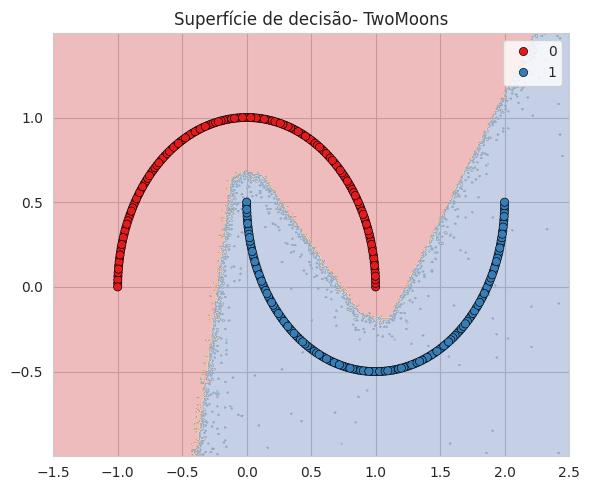

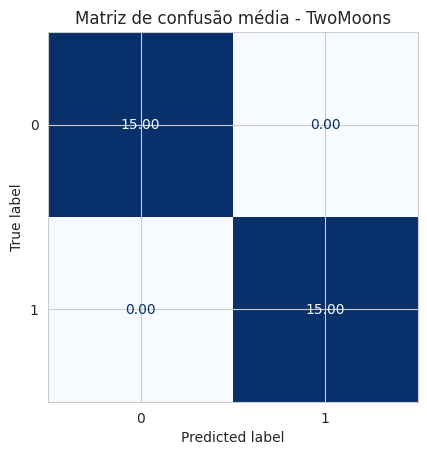


TREINO CONFIG FINAL- Ripley
Fold 01: ACC=0.9280 F1=0.9268
Fold 02: ACC=0.9040 F1=0.9032
Fold 03: ACC=0.9120 F1=0.9173
Fold 04: ACC=0.9440 F1=0.9421
Fold 05: ACC=0.8960 F1=0.8976
Fold 06: ACC=0.9520 F1=0.9531
Fold 07: ACC=0.9600 F1=0.9600


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 08: ACC=0.9200 F1=0.9206
Fold 09: ACC=0.8960 F1=0.9037
Fold 10: ACC=0.9194 F1=0.9180


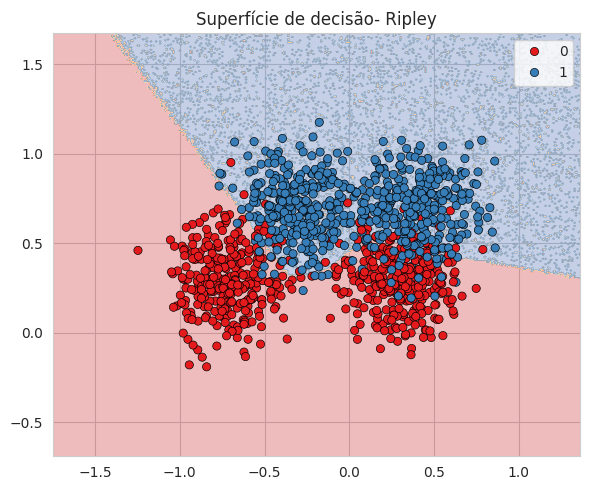

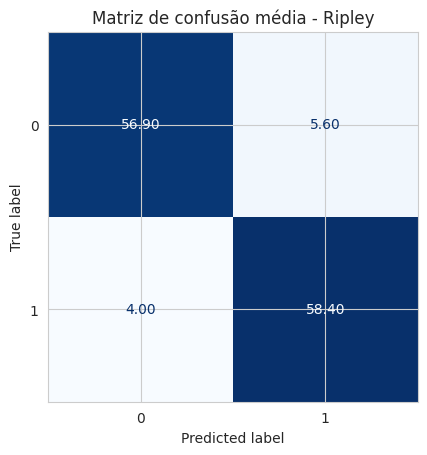


TREINO CONFIG FINAL- Banana
Fold 01: ACC=0.8830 F1=0.8640


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 02: ACC=0.8981 F1=0.8816
Fold 03: ACC=0.9113 F1=0.8989
Fold 04: ACC=0.9283 F1=0.9163
Fold 05: ACC=0.8792 F1=0.8512
Fold 06: ACC=0.9113 F1=0.8980
Fold 07: ACC=0.9113 F1=0.8962
Fold 08: ACC=0.8811 F1=0.8558
Fold 09: ACC=0.8943 F1=0.8756
Fold 10: ACC=0.9170 F1=0.9056


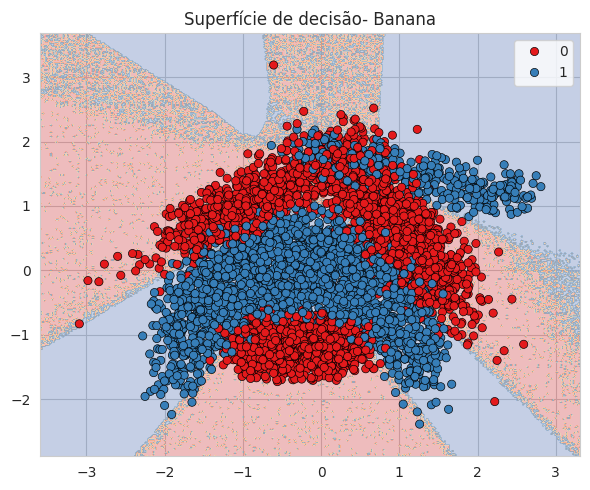

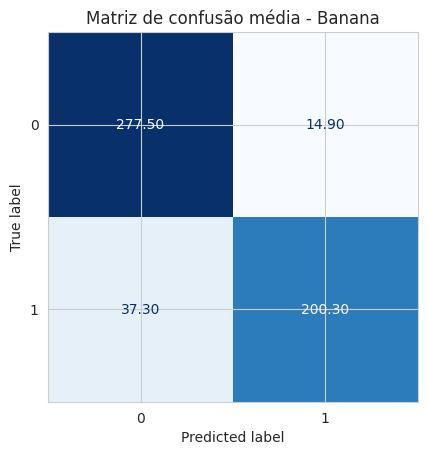

In [ ]:
# ----------------------------------- EXECUÇÃO FINAL -----------------------------
"""
ESSE CÓDIGO EXECUTA O RESULTADO FINAL DE CADA DATASET DE MANEIRA AUTOMÁTICA
O CÓDIGO TAMBÉM PLOTA A SUPERFÍCIE DE DECISÃO COM O MODELO OTIMIZADO ESCOLHIDO
CONSIDERANDO TODOS OS DADADOS.
"""

RESULTS = {}


for nm,b in DATASETS.items():
    print("\n"+"="*80)
    print("TREINO CONFIG FINAL-", nm)
    hp = BEST[nm]

    stats, cm_mean, npar = kfold_experiment(b.data, b.target, n_splits=10,
                                            h1=hp["h1"],
                                            h2=hp["h2"],
                                            dropout=hp["drop"],
                                            lr=hp["lr"], wd=hp["wd"],
                                            bs=hp["bs"],
                                            epochs=400, patience=40, name = nm)

    RESULTS[nm] = dict(metrics=stats, cm=cm_mean, params=npar)


  #Modelo final(para superfície de decisão), usando os hiperparametros e todos os dados

    scaler = StandardScaler().fit(b.data)
    Xt = torch.tensor(scaler.transform(b.data), dtype=torch.float32, device=DEVICE)
    yt = torch.tensor(b.target, dtype=torch.long, device=DEVICE)
    if nm == "Banana" or nm == "TwoMoons":
      net = TinyMLP1(hp["h1"], hp["h2"], hp["drop"]).to(DEVICE)
    elif nm == "Ripley":
      net = TinyMLP2(hp["h1"], hp["h2"], hp["drop"]).to(DEVICE)
    opt = torch.optim.Adam(net.parameters(), lr=hp["lr"], weight_decay=hp["wd"])
    dl = DataLoader(TensorDataset(Xt, yt), batch_size=hp["bs"], shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    for _ in range(300):
      _ = train_epoch(net, dl, opt, loss_fn)

    plot_surface(net, b.data, b.target, scaler, title=f"Superfície de decisão- {nm}")
    disp = ConfusionMatrixDisplay(cm_mean, display_labels=['0', '1'])
    disp.plot(cmap='Blues', colorbar=False, values_format=".2f")
    plt.title(f"Matriz de confusão média - {nm}")
    plt.show()


O Dataset Ripley foi treinado com uma MLP DIFERENTE, ou seja, com uma layer normalizante, pois o mesmo apresentou uma melhoria razoavelmente significativa, diferentemente dos outros datasets. Se optassemos por introduzir a mesma arquitetura para ambos os datasets, alcançariamos os mesmos resultados nos datasets Banana e TwoMoons, porém com uma complexidade desnecessária.

In [ ]:
#--------------------------------RELATÓRIO FINAL ----------------------------------

print("\n"+"#"*90)
print("RELATÓRIO FINAL (10 folds) - média ± desvio")


for nm, res in RESULTS.items():
  print(f"\n{nm} (Parâmetros:{res['params']})")
  for k in ['acc', 'prec', 'f1']:
    mu, sd = res['metrics'][k]
    print(f" {k.upper():4s}: {mu:.4f} ± {sd:.4f}")


##########################################################################################
RELATÓRIO FINAL (10 folds) - média ± desvio

TwoMoons (Parâmetros:70)
 ACC : 1.0000 ± 0.0000
 PREC: 1.0000 ± 0.0000
 F1  : 1.0000 ± 0.0000

Ripley (Parâmetros:94)
 ACC : 0.9231 ± 0.0215
 PREC: 0.9147 ± 0.0400
 F1  : 0.9243 ± 0.0203

Banana (Parâmetros:114)
 ACC : 0.9015 ± 0.0160
 PREC: 0.9312 ± 0.0170
 F1  : 0.8843 ± 0.0210
